# Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis
import yfinance as yf
from Stock_Data import get_close
from Rebalancing import *

from Git import *

In [3]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

In [5]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [6]:
days=(today-start_date).days
days

2100

In [7]:
remaining=days%500
numbers_of_table=days//500

In [8]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()


In [9]:
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)

In [10]:
market_data_us=get_close(['SPY','GOLD.PA','BTC-USD'],start=start_date.strftime("%Y-%m-%d"),end=today.strftime("%Y-%m-%d"))
market_data_us.index=pd.to_datetime(market_data_us.index)
market_data_us = market_data_us[~market_data_us.index.duplicated(keep='first')]
market_data_us=market_data_us.sort_index().dropna()
market_data_us_returns=market_data_us.pct_change().sort_index()

In [11]:
# tickers=['BTC-USD','ETH-USD','XRP-USD','BNB-USD','SOL-USD','DOGE-USD','TRX-USD','WTRX-USD','STETH-USD','ADA-USD','HYPE32196-USD',
#         'WBTC-USD','WSTETH-USD','SUI20947-USD','BCH-USD','LINK-USD']
# scope_prices=get_close(tickers,start=start_date.strftime("%Y-%m-%d"),end=today.strftime("%Y-%m-%d"))
# scope_prices.index=pd.to_datetime(scope_prices.index)
# scope_prices= scope_prices[~scope_prices.index.duplicated(keep='first')]
# scope_prices=scope_prices.sort_index().dropna()

In [12]:
# prices=prices.loc[market_data_us.index]
# prices['GOLD.PA']=market_data_us['GOLD.PA']

In [13]:
# correlation_btc=market_data_us_returns['GOLD.PA'].rolling(30).corr(market_data_us_returns['BTC-USD']).dropna()
# correlation_spy=market_data_us_returns['GOLD.PA'].rolling(30).corr(market_data_us_returns['SPY']).dropna()

# beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['BTC-USD']).dropna()/pct_change['BTC-USD'].rolling(30).var().dropna())

In [14]:
# info=pd.DataFrame()
# info['Correlation SPY']=correlation_spy
# info['Correlation BTC']=correlation_btc

In [15]:
# info.iloc[-30:]

In [16]:
# info.plot()
Binance.get_market_cap()[['Long name','Ticker','Market Cap','Supply']].set_index('Ticker').iloc[:20]

,Long name,Market Cap,Supply
Ticker,,,
BTCUSDT,Bitcoin,2.327217e+12,19806450
ETHUSDT,Ethereum,5.220266e+11,120473322
XRPUSDT,XRP,1.697448e+11,57410227039
BNBUSDT,BNB,1.469891e+11,144006693
SOLUSDT,Solana,1.063604e+11,482995424
USDCUSDT,USDC,4.555856e+10,45590471931
DOGEUSDT,Dogecoin,3.644186e+10,147508016384
ADAUSDT,Cardano,2.975545e+10,35151153813
TRXUSDT,TRON,2.948618e+10,86191683773


In [17]:
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]


In [18]:
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()


In [19]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [20]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [22]:
month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

In [23]:
results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

In [24]:
for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

In [25]:
rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

# correlation_threshold=0.5
# gold_limit=0.0
# rolling_optimization_adjusted=rolling_optimization.copy()

# correlation=pd.DataFrame(index=dates_end)
# correlation['Correlation']=correlation_spy
# correlation=correlation.ffill().bfill()


In [26]:
# for date in dates_end:
    
#     if abs(correlation.loc[date].item())<correlation_threshold:
        
#         temp=rolling_optimization_adjusted.loc[date]
#         sum_numerator=temp.loc[temp.index!='GOLD.PA'].sum()-gold_limit
    
#         normalized_weights=temp.loc[temp.index!='GOLD.PA']*sum_numerator
#         normalized_weights['GOLD.PA']=gold_limit
#         rolling_optimization_adjusted.loc[date]=normalized_weights
#     else:
        
#         continue

In [27]:
performance=pd.DataFrame()

results=(rebalanced_dynamic_quantities(dataframe,rolling_optimization)*dataframe).sum(axis=1)
performance['Fund']=results
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change(fill_method=None)

((1+performance_pct).cumprod()*100)

,Fund,Bitcoin
2019-12-31,NaN,NaN
2020-01-01,100.645147,100.078107
2020-01-02,97.331383,96.810109
2020-01-03,102.386058,102.080962
2020-01-04,102.920884,102.208130
...,...,...
2025-09-27,43873.821956,1523.729610
2025-09-28,44238.722185,1558.865387
2025-09-29,44688.001962,1588.718637
2025-09-30,44404.092732,1585.063021


<Axes: >

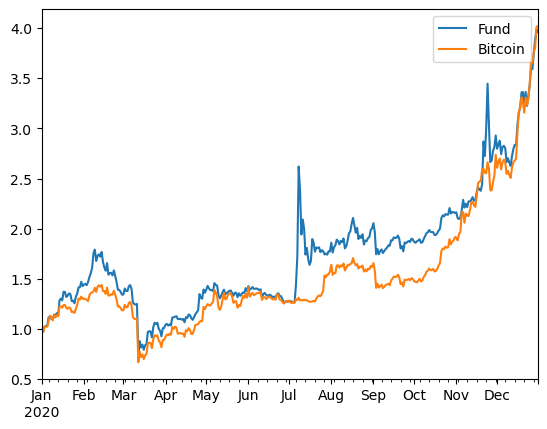

In [28]:
(1+performance_pct.loc['2020':'2020']).cumprod().plot()

In [29]:
years=sorted(list(set(performance.index.year)))

month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

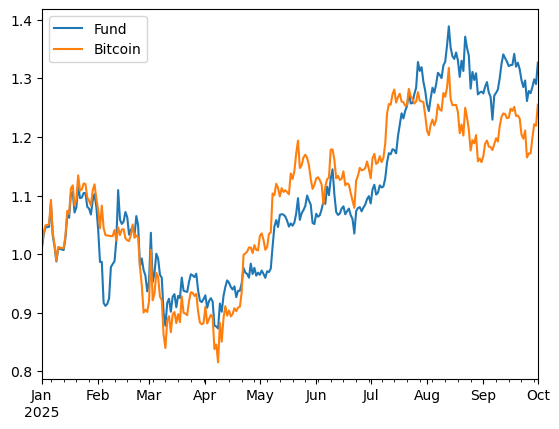

In [30]:
(1+performance_pct.loc['2025':]).cumprod().plot()

In [31]:
year_returns={}
year_vol={}
year_tracking_error={}
year_sharpe_ratio={}

for year in years:
    temp=performance_pct.loc[str(year)]
    year_vol[year]=temp.std()*np.sqrt(252)
    year_tracking_error[year]=(temp['Fund']-temp['Bitcoin']).std()*np.sqrt(252)
    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_sharpe_ratio[year]=perf_year/(temp.std()*np.sqrt(252))
    year_returns[year]=perf_year


In [32]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2019,2020,2021,2022,2023,2024,2025
Fund,0.0,2.936854,13.194955,-0.558218,1.828953,3.616612,0.312635
Bitcoin,0.0,3.016697,0.575665,-0.653364,1.544636,1.118084,0.241434


In [33]:
year_vol_dataframe=pd.DataFrame(year_vol)
year_vol_dataframe

,2019,2020,2021,2022,2023,2024,2025
Fund,NaN,0.844397,1.079474,0.517856,0.434699,0.567659,0.333912
Bitcoin,NaN,0.627152,0.673837,0.529616,0.366136,0.441022,0.346591


In [34]:
year_tracking_error_dataframe=pd.DataFrame(year_tracking_error.items(),columns=['Date','Tracking Error']).set_index('Date').T.round(6)
year_tracking_error_dataframe

Date,2019,2020,2021,2022,2023,2024,2025
Tracking Error,NaN,0.627143,0.772327,0.281363,0.347145,0.594824,0.217988


In [35]:
year_sharpe_ratio_dataframe=pd.DataFrame(year_sharpe_ratio)
year_sharpe_ratio_dataframe

,2019,2020,2021,2022,2023,2024,2025
Fund,NaN,3.478048,12.223509,-1.077942,4.207402,6.371100,0.936281
Bitcoin,NaN,4.810150,0.854309,-1.233656,4.218749,2.535209,0.696594


In [36]:
month_returns={}
month_vol={}
month_tracking_error={}
monthly_sharpe_ratio={}

for month in month_year:
    temp=performance_pct.loc[str(month)]
    month_vol[month]=temp.std()*np.sqrt(252)
    month_tracking_error[month]=(temp['Fund']-temp['Bitcoin']).std()*np.sqrt(252)
    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year
    monthly_sharpe_ratio[month]=perf_year/(temp.std()*np.sqrt(252))
    
#month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [37]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,...,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10
Fund,0.0,0.417557,-0.070261,-0.248649,0.305888,-0.010234,-0.106687,0.389475,0.076983,-0.079315,...,0.069272,-0.101246,-0.031995,0.041609,0.089787,0.028133,0.176891,0.017144,0.012452,0.0
Bitcoin,0.0,0.298859,-0.091746,-0.248649,0.297622,0.070388,-0.104131,0.227844,-0.012851,-0.096073,...,0.082859,-0.161828,-0.040836,0.105846,0.083967,0.014233,0.095409,-0.044587,0.044046,0.0


In [38]:
month_vol_dataframe=pd.DataFrame(month_vol)
month_vol_dataframe

,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,...,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10
Fund,NaN,0.607610,0.581343,1.484816,0.557370,0.395861,0.276619,1.867153,0.479717,0.480444,...,0.340531,0.538117,0.496818,0.289097,0.240467,0.246235,0.209116,0.293099,0.214586,NaN
Bitcoin,NaN,0.477872,0.425471,1.484816,0.612317,0.575818,0.418010,0.366030,0.375112,0.462865,...,0.355082,0.317625,0.555310,0.456256,0.301380,0.266026,0.220701,0.296888,0.202519,NaN


In [39]:
month_tracking_error_dataframe=pd.DataFrame(month_tracking_error.items(),columns=['Date','Tracking Error']).set_index('Date').T.round(6)
month_tracking_error_dataframe

Date,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,...,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10
Tracking Error,NaN,0.284122,0.336984,0.0,0.449492,0.275986,0.216118,1.86152,0.234894,0.067195,...,0.023028,0.451938,0.086178,0.265437,0.240402,0.221609,0.168412,0.097807,0.152474,NaN


In [40]:
month_sharpe_ratio_dataframe=pd.DataFrame(monthly_sharpe_ratio)
month_sharpe_ratio_dataframe

,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,...,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10
Fund,NaN,0.687213,-0.120859,-0.167461,0.548806,-0.025853,-0.385681,0.208593,0.160477,-0.165086,...,0.203422,-0.188148,-0.064400,0.143927,0.373388,0.114254,0.845900,0.058492,0.058026,NaN
Bitcoin,NaN,0.625395,-0.215634,-0.167461,0.486059,0.122240,-0.249112,0.622476,-0.034260,-0.207562,...,0.233352,-0.509495,-0.073537,0.231988,0.278608,0.053501,0.432301,-0.150180,0.217492,NaN


In [41]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Fund Vol']

In [42]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.525034
Fund Vol,0.691874
Bench Vol,0.519148
Fund Return,444.040927
Bench Return,15.850630
Sharpe Ratio,3.453949


In [43]:
q=(rebalanced_dynamic_quantities(dataframe,rolling_optimization))

In [107]:
index=-1
current_position=Binance.get_inventory().round(4)
last_prices=Binance.get_price(list(q.iloc[index].keys()))
pd.DataFrame(q.iloc[index]*last_prices).T/pd.DataFrame(q.iloc[index]*last_prices).T.sum()*(current_position.loc['Total']['Price in USDT']-current_position.loc['OMUSDT']['Price in USDT'])

,2025-10-01
BTCUSDT,1454.883385
ETHUSDT,0.000000
XRPUSDT,0.000000
BNBUSDT,0.000000
DOGEUSDT,0.000000
ADAUSDT,0.000000
TRXUSDT,637.151615
LINKUSDT,0.000000
XLMUSDT,0.000000
BCHUSDT,0.000000


In [45]:
current_positions=Binance.get_inventory().round(4)
current_positions.columns=['Current Portfolio in USDT','Current Weights']
amount=current_positions.loc['Total']['Current Portfolio in USDT']
last_prices=Binance.get_price(list(q.iloc[-2].keys()))
positions=pd.DataFrame(q.iloc[-2]*last_prices).T
positions['Weights Model']=positions[positions.columns]/positions[positions.columns].sum()
positions['Mark To Market Model']=positions['Weights Model']*amount
condition=current_positions.index!='Total'
portfolio=pd.concat([positions[['Mark To Market Model','Weights Model']],current_positions.loc[condition]],axis=1).fillna(0)
portfolio['Spread']=portfolio['Mark To Market Model']-portfolio['Current Portfolio in USDT']
portfolio.loc['Total']=portfolio.sum(axis=0)
portfolio.sort_values(by='Weights Model',ascending=False).round(4)

,Mark To Market Model,Weights Model,Current Portfolio in USDT,Current Weights,Spread
Total,2176.3780,1.0000,2176.3780,0.9999,0.0000
TRXUSDT,1218.4082,0.5598,662.9516,0.3046,555.4566
BTCUSDT,957.9698,0.4402,1430.9796,0.6575,-473.0098
ETHUSDT,0.0000,0.0000,0.1577,0.0001,-0.1577
XRPUSDT,0.0000,0.0000,0.0000,0.0000,0.0000
BNBUSDT,0.0000,0.0000,0.0269,0.0000,-0.0269
DOGEUSDT,0.0000,0.0000,0.0000,0.0000,0.0000
ADAUSDT,0.0000,0.0000,0.0000,0.0000,0.0000
LINKUSDT,0.0000,0.0000,0.0000,0.0000,0.0000
XLMUSDT,0.0000,0.0000,0.0000,0.0000,0.0000


In [46]:
git.create_or_replace_notebook("Active Crypto Strategy.ipynb")

File 'Active Crypto Strategy.ipynb' exists. Replacing the file...
✅ File 'Active Crypto Strategy.ipynb' successfully pushed/updated to GitHub!


In [47]:
dates_end2=dates_end.copy()
dates_end2=dates_end2[:-1]
date=dates_end2[-2]
last_weights=rolling_optimization.loc[date]
weights=pd.DataFrame(last_weights)
weights.columns=['Weights Model']
weights

,Weights Model
BTCUSDT,0.422916
ETHUSDT,0.000000
XRPUSDT,0.000000
BNBUSDT,0.000000
DOGEUSDT,0.000000
ADAUSDT,0.000000
TRXUSDT,0.577084
LINKUSDT,0.000000
XLMUSDT,0.000000
BCHUSDT,0.000000


In [48]:
rolling_optimization

,BTCUSDT,ETHUSDT,XRPUSDT,BNBUSDT,DOGEUSDT,ADAUSDT,TRXUSDT,LINKUSDT,XLMUSDT,BCHUSDT
2020-01-01,0.100000,0.1,0.10000,0.100000,0.100000,0.1,0.100000,0.100000,0.1,0.10000
2020-01-31,0.363342,0.0,0.00000,0.000000,0.616559,0.0,0.000000,0.020099,0.0,0.00000
2020-02-28,1.000000,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000
2020-03-31,0.000000,0.0,0.00000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.00000
2020-04-30,0.000000,0.0,0.39984,0.000000,0.600160,0.0,0.000000,0.000000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.160215,0.0,0.00000,0.490107,0.000000,0.0,0.349678,0.000000,0.0,0.00000
2025-07-31,0.479123,0.0,0.00000,0.130886,0.000000,0.0,0.350211,0.000000,0.0,0.03978
2025-08-29,0.422916,0.0,0.00000,0.000000,0.000000,0.0,0.577084,0.000000,0.0,0.00000
2025-09-30,0.694351,0.0,0.00000,0.000000,0.000000,0.0,0.305649,0.000000,0.0,0.00000


In [49]:
history={}

for date in rolling_optimization.index:

    history[date]=rolling_optimization.loc[date]

In [50]:
np.sum(pd.DataFrame(history).T>0,axis=0).sort_values()/rolling_optimization.shape[0]

ADAUSDT     0.084507
LINKUSDT    0.084507
ETHUSDT     0.112676
BCHUSDT     0.112676
XRPUSDT     0.225352
DOGEUSDT    0.225352
XLMUSDT     0.225352
BNBUSDT     0.492958
BTCUSDT     0.676056
TRXUSDT     0.704225
dtype: float64